# Lung Cancer New Mexico Example

Implemented with `echelon_py.contrib` functionalities.

Data is acquired from:

* https://www.satscan.org/datasets/nmlung/

    * Raw data files for analyzing the spatial and temporal distribution of lung cancer incidence in New Mexico, 1973 - 1991. Covariates included are age, race and sex.

The analysis is a partial reproduction of

* Kurihara, K., Ishioka, F., & Kajinishi, S. (2020). Spatial and temporal clustering based on the echelon scan technique and software analysis. Japanese Journal of Statistics and Data Science, 3(1), 313–332.
    
especially its Section 4.4.

In [167]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Version Information

In [168]:
import echelon

## For shapefile -> adjacency conversion
import networkx  # For graph handling.
import geopandas  # For reading shapefiles.
import libpysal  # For constructing "Queen" neighborhoods.

import matplotlib
# # For some reason, NetworkX plot functionality (nx.draw()) seems to fail with a newer matplotlib:
# # https://stackoverflow.com/questions/63198347/attributeerror-module-matplotlib-cbook-has-no-attribute-iterable
# assert matplotlib.__version__ =='2.2.3'

import echelon.contrib.geo as echelon_geo

for module in [echelon, networkx, matplotlib, geopandas, libpysal]:
    print(module.__name__, module.__version__)

echelon 1.0.3
networkx 2.6.3
matplotlib 3.4.3
geopandas 0.10.2
libpysal 4.5.1


## Download data

In [169]:
import urllib.request
from pathlib import Path

## Configuration
data_dir = Path('data/lung-cancer-1')
data_dir.mkdir(exist_ok=True)

## Download data files
for filename in ['nm_l_readme.txt', 'nm-km.geo', 'lung.cas', 'nm-m.pop']:
    if not (data_dir / filename).exists():
        urllib.request.urlretrieve('https://www.satscan.org/datasets/nmlung/' + filename, data_dir / filename)

## Download Shapefile
filename = '2007fe_35_county00.original.zip'
if not (data_dir / filename).exists():
    urllib.request.urlretrieve('http://gstore.unm.edu/apps/rgisarchive/datasets/609320d1-8d95-47a7-818f-64ca7bc66c3d/2007fe_35_county00.original.zip', data_dir / filename)

## Extract shapefile from zip
shapefile_name = 'fe_2007_35_county00.shp'
if not (data_dir / shapefile_name).exists():
    import zipfile
    with zipfile.ZipFile(data_dir / filename, "r") as f:
        f.extractall(data_dir)

## List data directory contents
[item.name for item in data_dir.iterdir()]

['fe_2007_35_county00.prj',
 '.DS_Store',
 '2007fe_35_county00.original.zip',
 'nm-m.pop',
 'fe_2007_35_county00.shp.xml',
 'nm-km.geo',
 'fe_2007_35_county00.shx',
 'fe_2007_35_county00.shp',
 'lung.cas',
 'nm_l_readme.txt',
 'fe_2007_35_county00.dbf']

## Load Data

### lung.cas: lung cancer incidence file

All lung cancer cases are malignant and were diagnosed during the 1973-1991 period. 

* 1st column:   name of county (Note: In 1981, Valencia county was split into Cibola and Valencia counties. In this data, they are treated as one during the whole time period listed under Valencia.)

* 2nd column:  number cancer cases

* 3rd column: Month of Diagnosis

  | January 1973 = 2001
  | February 1973 = 2002
  | etc.


* 4th column: Age Group

   | 1 = ages < 5
   | 2 = ages 5-9
   | 3 = ages 10-14
   | 18 = ages 85+


* 5th column: Sex

    | 1 = Male
    | 2 = Female

* Data Source: National Cancer Institutes Surveillance, Epidemiology and End Results (SEER) Program.
* Explanation excerpt from: https://www.satscan.org/datasets/nmlung/nm_l_readme.txt

In [180]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

df_cases = pd.read_csv(data_dir / 'lung.cas', index_col=False, sep='\s+',
           names=['county', 'cases', 'month', 'age group', 'sex'],
           dtype={'cases': 'Int64'},
           converters = {
                'month': lambda x: (datetime.date(1973, 1, 1) + relativedelta(months=int(x) - 2001)).strftime('%Y-%m'),
                'age group': lambda x: ['< 5', *[f'{i * 5}-{i * 5+4}' for i in range(1, 17)], '85+'][int(x)-1],
                'sex': lambda x: {'1': 'male', '2': 'female'}[x]
           })
df_cases['county'] = df_cases['county'].map(lambda x: x.replace('Guadelupe', 'Guadalupe'))
df_cases

,county,cases,month,age group,sex
0,Bernalillo,1,1973-01,40-44,male
1,Bernalillo,2,1973-01,45-49,male
2,Bernalillo,2,1973-01,50-54,male
3,Bernalillo,1,1973-01,50-54,female
4,Bernalillo,1,1973-01,65-69,male
...,...,...,...,...,...
7788,Valencia,1,1991-10,85+,female
7789,Valencia,1,1991-11,65-69,female
7790,Valencia,1,1991-11,70-74,female
7791,Valencia,1,1991-11,80-84,male


### nm-m.pop: background population file

* 1st column:   name of county
* 2nd column:   month
* 3rd column:   population, for that county, month, age group and sex (Note: Yearly population counts are from the census, and are assigned to July of each year.)
* 4th column:   age group
* 5th column:   sex


* Data Source: United States Census Bureau.
* Explanation excerpt from: https://www.satscan.org/datasets/nmlung/nm_l_readme.txt

In [181]:
df_population = pd.read_csv(data_dir / 'nm-m.pop', index_col=False, sep='\s+',
            names=['county', 'year', 'population', 'age group', 'sex'],
            converters = {
                'year': lambda x: (datetime.date(1973, 1, 1) + relativedelta(months=int(x) - 2001)).strftime('%Y'),
                'age group': lambda x: ['< 5', *[f'{i * 5}-{i * 5+4}' for i in range(1, 17)], '85+'][int(x)-1],
                'sex': lambda x: {'1': 'male', '2': 'female'}[x]
            },
            skipfooter=1, # There is a blank line at the end (that is wrongly parsed without skipping)
           )
df_population['county'] = df_population['county'].map(lambda x: x.replace('Guadelupe', 'Guadalupe'))
df_population.groupby(['county', 'year', 'age group', 'sex'])['population'].sum().reset_index()

,county,year,age group,sex,population
0,Bernalillo,1973,10-14,female,18827
1,Bernalillo,1973,10-14,male,19458
2,Bernalillo,1973,15-19,female,19121
3,Bernalillo,1973,15-19,male,18677
4,Bernalillo,1973,20-24,female,17636
...,...,...,...,...,...
21883,Valencia,1991,80-84,male,306
21884,Valencia,1991,85+,female,328
21885,Valencia,1991,85+,male,193
21886,Valencia,1991,< 5,female,3021


### nm-km.pop: geographic coordinates file

**This file is not used.**

Geographic coordinate of the county seats in units of kilometers.

* Data Source: Rand McNally Cosmopolitan World Atlas
* Explanation excerpt from: https://www.satscan.org/datasets/nmlung/nm_l_readme.txt

In [182]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

df_coord = pd.read_csv(data_dir / 'nm-km.geo', index_col=False, sep='\s+',
                       names=['county', 'coord_x', 'coord_y'],
                      )
df_coord.head(3)

,county,coord_x,coord_y
0,Bernalillo,219,338
1,Catron,27,189
2,Chaves,418,156


### Shapefile of New Mexico

['Eddy' 'McKinley' 'Socorro' 'Colfax' 'Catron' 'Torrance' 'Lea' 'Luna'
 'Grant' 'SanMiguel' 'Otero' 'SantaFe' 'DeBaca' 'Chaves' 'Roosevelt'
 'Curry' 'Hidalgo' 'Valencia' 'Union' 'Bernalillo' 'Lincoln' 'Sierra'
 'Sandoval' 'SanJuan' 'Guadalupe' 'Quay' 'RioArriba' 'Taos' 'Mora'
 'Harding' 'LosAlamos' 'DonaAna']


,STATEFP00,COUNTYFP00,CNTYIDFP00,NAME00,NAMELSAD00,LSAD00,CLASSFP00,MTFCC00,UR00,FUNCSTAT00,geometry
0,35,015,35015,Eddy,Eddy County,06,H1,G4020,M,A,"POLYGON ((-104.85155 32.36208, -104.85161 32.3..."
1,35,031,35031,McKinley,McKinley County,06,H1,G4020,M,A,"POLYGON ((-108.87030 36.00266, -108.86314 36.0..."
2,35,053,35053,Socorro,Socorro County,06,H1,G4020,M,A,"POLYGON ((-107.71176 33.72561, -107.71178 33.7..."


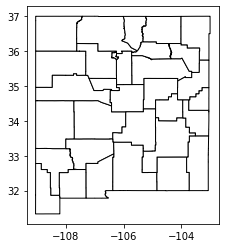

In [183]:
import numpy as np
import geopandas as gpd
import networkx as nx
from libpysal import weights
from pathlib import Path

gdf = gpd.read_file(data_dir / shapefile_name)

######
## Combine Valencia and Cibola polygons.
######
_Cibola = gdf[gdf['NAME00'] == 'Cibola']
_Valencia = gdf[gdf['NAME00'] == 'Valencia']
from shapely.ops import cascaded_union
gdf.at[_Valencia.index, 'geometry'] = cascaded_union([
    _Valencia['geometry'].iloc[0], _Cibola['geometry'].iloc[0]
])
gdf = gdf.drop(_Cibola.index).reset_index(drop=True)
######

gdf['NAME00'] = gdf['NAME00'].map(lambda x: x.replace(" ", ""))

print(gdf['NAME00'].unique())

from IPython.display import display
display(gdf.head(3))

%matplotlib inline
gdf.plot(color='white', edgecolor='black')
None

## Format Data

In [186]:
df_cases_orig = df_cases
df_population_orig = df_population

In [211]:
df_cases = df_cases_orig.copy()
df_population = df_population_orig.copy()

def year_group_fn(year):
    for group, (start, end) in enumerate([
        (1973, 1975),
        (1976, 1978),
        (1979, 1981),
        (1982, 1984), 
        (1985, 1987),
        (1988, 1991)], start=1):
        if start <= year and year <= end:
            return group
    return None

_time = pd.to_datetime(df_cases['month'])
df_cases['year'] = _time.map(lambda x: x.year)
df_cases['year_group'] = df_cases['year'].map(year_group_fn).astype('Int64')
df_cases = df_cases.drop(['month', 'year'], axis=1)
df_cases = df_cases.groupby(['county', 'age group', 'sex', 'year_group']).sum().reset_index()

df_population['year_group'] = df_population['year'].astype(int).map(year_group_fn).astype('Int64')
df_population = df_population.drop('year', axis=1)

## Calculate SMR (observations to construct the echelons)
df = df_population.merge(df_cases, on=['year_group', 'sex', 'age group', 'county'])
C = df.groupby(['age group', 'sex'])['cases'].sum()
N = df.groupby(['age group', 'sex'])['population'].sum()
P = C / N
df = df.merge(P.reset_index().rename(columns={0: 'P'}), on=['age group', 'sex'])
Lambda = (df.groupby(['county', 'year_group'])[['P', 'population']]
          .apply(lambda r: (r['P'] * r['population']).sum())
          .reset_index().rename(columns={0: 'lambda'})
         )
Cases = df.groupby(['county', 'year_group'])['cases'].sum().reset_index()
data = Cases.merge(Lambda, on=['county', 'year_group'])
data['SMR'] = data['cases'] / data['lambda']
# data = data.drop(['cases', 'lambda'], axis=1)
data

,county,year_group,cases,lambda,SMR,adjacency,id
0,Bernalillo,1,2790,3740.500145,0.745890,"[0, 1, 141, 147, 171, 183]",0
1,Bernalillo,2,3519,4223.033901,0.833287,"[0, 1, 2, 142, 148, 172, 184]",1
2,Bernalillo,3,3879,4811.930520,0.806121,"[1, 2, 3, 143, 149, 173, 185]",2
3,Bernalillo,4,4356,5267.714546,0.826924,"[2, 3, 4, 144, 150, 174, 186]",3
4,Bernalillo,5,4869,5787.776968,0.841256,"[3, 4, 5, 145, 151, 175, 187]",4
...,...,...,...,...,...,...,...
184,Valencia,2,396,488.954362,0.809892,"[1, 7, 94, 142, 160, 172, 183, 184, 185]",184
185,Valencia,3,840,585.089995,1.435677,"[2, 8, 95, 143, 161, 173, 184, 185, 186]",185
186,Valencia,4,1404,614.507771,2.284755,"[3, 9, 96, 144, 162, 174, 185, 186, 187]",186
187,Valencia,5,1728,742.053306,2.328674,"[4, 10, 97, 145, 163, 175, 186, 187, 188]",187


## Define adjacency

### Spatial Adjacency

In [222]:
from echelon.contrib.geo import GISAdjacency
from IPython.display import display
adjacency = GISAdjacency(gdf, id_col='NAME00')
adjacency_df = adjacency.to_series()
display(adjacency_df)
Spatial_adjacency_dict = adjacency_df.set_index('NAME00').to_dict()['adjacency']

,NAME00,adjacency
0,Eddy,"[Otero, Chaves, Lea]"
1,McKinley,"[Valencia, Sandoval, SanJuan]"
2,Socorro,"[Valencia, Lincoln, Catron, Torrance, Sierra]"
3,Colfax,"[Union, Taos, Mora, Harding]"
4,Catron,"[Grant, Valencia, Socorro, Sierra]"
5,Torrance,"[Valencia, Socorro, Bernalillo, Lincoln, Guada..."
6,Lea,"[Eddy, Chaves, Roosevelt]"
7,Luna,"[Hidalgo, Grant, Sierra, DonaAna]"
8,Grant,"[Hidalgo, Catron, Sierra, Luna]"
9,SanMiguel,"[Torrance, Guadalupe, Quay, SantaFe, Mora, Har..."


### Temporal Adjacency

In [224]:
year_groups = data.year_group.unique().tolist()
lag = 1
Temporal_adjacency_dict = {
    year_group: [_yg for _yg in range(year_group-lag, year_group+lag+1, 1)
                            if _yg in year_groups]
    for year_group in year_groups
}
Temporal_adjacency_dict

{1: [1, 2], 2: [1, 2, 3], 3: [2, 3, 4], 4: [3, 4, 5], 5: [4, 5, 6], 6: [5, 6]}

In [228]:
## Same time + neighboring region = adjacent
## Neighboring time + same region = adjacent
data['adjacency'] = data.apply(lambda r:
                               data[np.logical_or(
                                   np.logical_and(
                                       data['county'].isin(Spatial_adjacency_dict[r['county']]),
                                       data['year_group'] == r['year_group']
                                   ),
                                   np.logical_and(
                                       data['county'] == r['county'],
                                       data['year_group'].isin(Temporal_adjacency_dict[r['year_group']]),
                                   )
                               )].index.to_list(), axis=1)
## We need a column to indicate the adjacency ID
data['id'] = data.index
data

,county,year_group,cases,lambda,SMR,adjacency,id
0,Bernalillo,1,2790,3740.500145,0.745890,"[0, 1, 141, 147, 171, 183]",0
1,Bernalillo,2,3519,4223.033901,0.833287,"[0, 1, 2, 142, 148, 172, 184]",1
2,Bernalillo,3,3879,4811.930520,0.806121,"[1, 2, 3, 143, 149, 173, 185]",2
3,Bernalillo,4,4356,5267.714546,0.826924,"[2, 3, 4, 144, 150, 174, 186]",3
4,Bernalillo,5,4869,5787.776968,0.841256,"[3, 4, 5, 145, 151, 175, 187]",4
...,...,...,...,...,...,...,...
184,Valencia,2,396,488.954362,0.809892,"[1, 7, 94, 142, 160, 172, 183, 184, 185]",184
185,Valencia,3,840,585.089995,1.435677,"[2, 8, 95, 143, 161, 173, 184, 185, 186]",185
186,Valencia,4,1404,614.507771,2.284755,"[3, 9, 96, 144, 162, 174, 185, 186, 187]",186
187,Valencia,5,1728,742.053306,2.328674,"[4, 10, 97, 145, 163, 175, 186, 187, 188]",187


In [229]:
from echelon.api import DataFrameEchelonAnalysis

analyzer = DataFrameEchelonAnalysis()
result = analyzer(data, 'SMR', 'id', 'adjacency')
print(analyzer.dendrogram(result))

E37(143): [93, 95, 118, 97, 138, 148, 39, 130, 98, 149, 169, 142, 150, 120, 121, 73, 94, 133, 83, 129, 96, 135, 119, 0, 53, 151, 141, 165, 27, 170, 28, 147, 132, 143]
 (max: 0.7852166611411063)

├── E36(117): [168, 52, 167, 109, 139, 136, 36, 2, 108, 184, 183, 137, 3, 177, 22, 1, 4, 51, 37, 152, 144, 123, 50, 19, 70, 126, 122, 84, 117]
│    (max: 0.9017577799285885)
│   
│   ├── E35(86): [40, 145, 38, 79, 25, 42, 41, 24, 162, 106, 127, 153, 49, 86]
│   │    (max: 0.9708709734171175)
│   │   
│   │   ├── E34(12): [46, 75, 72, 18, 45, 157, 20, 26, 12]
│   │   │    (max: 1.0199178749255364)
│   │   │   
│   │   │   ├── E33(146): [107, 89, 111, 124, 13, 71, 112, 87, 91, 115, 166, 29, 43, 88, 16, 76, 146]
│   │   │   │    (max: 1.1411018643956194)
│   │   │   │   
│   │   │   │   ├── E32(100): [161, 5, 110, 44, 21, 156, 80, 48, 14, 90, 128, 15, 160, 125, 173, 179, 100]
│   │   │   │   │    (max: 1.2645618913181815)
│   │   │   │   │   
│   │   │   │   │   ├── E31(64): [180, 178, 140, 64]
│ 

In [230]:
hotspots = analyzer.hotspots(result, data=(data, 'id', 'lambda', 'cases'), score='binomial')
hotspots

,spot,score,c(Z),log_lambda
91,"[100, 179, 173, 125, 160, 15, 128, 90, 14, 48,...",2853.782391,41186,2853.782391
92,"[100, 179, 173, 125, 160, 15, 128, 90, 14, 48,...",2853.499930,41285,2853.499930
90,"[100, 179, 173, 125, 160, 15, 128, 90, 14, 48,...",2853.282031,40988,2853.282031
93,"[100, 179, 173, 125, 160, 15, 128, 90, 14, 48,...",2852.253340,41978,2852.253340
89,"[100, 179, 173, 125, 160, 15, 128, 90, 14, 48,...",2850.701359,40619,2850.701359
...,...,...,...,...
17,[62],3.391824,9,3.391824
100,[69],1.894181,567,1.894181
99,[85],0.678831,180,0.678831
101,[105],0.084364,261,0.084364


In [234]:
def groupby_hotspots(hotspots, data, by, id_col):
    _out = {}
    for val, group in data.groupby(by):
        _hotspots = hotspots.copy()
        _hotspots['spot'] = _hotspots['spot'].map(lambda ids: [idx for idx in ids if idx in group[id_col]])
        _out[val] = _hotspots
    return _out

In [235]:
for val, _hotspots in groupby_hotspots(hotspots, data, by='year_group', id_col='id').items():
    print(val)
    plotter.plot_hotspot(_hotspots, )

1


TypeError: plot_hotspot() missing 1 required positional argument: 'label_col'

## Bonus

Spatial adjacency plot

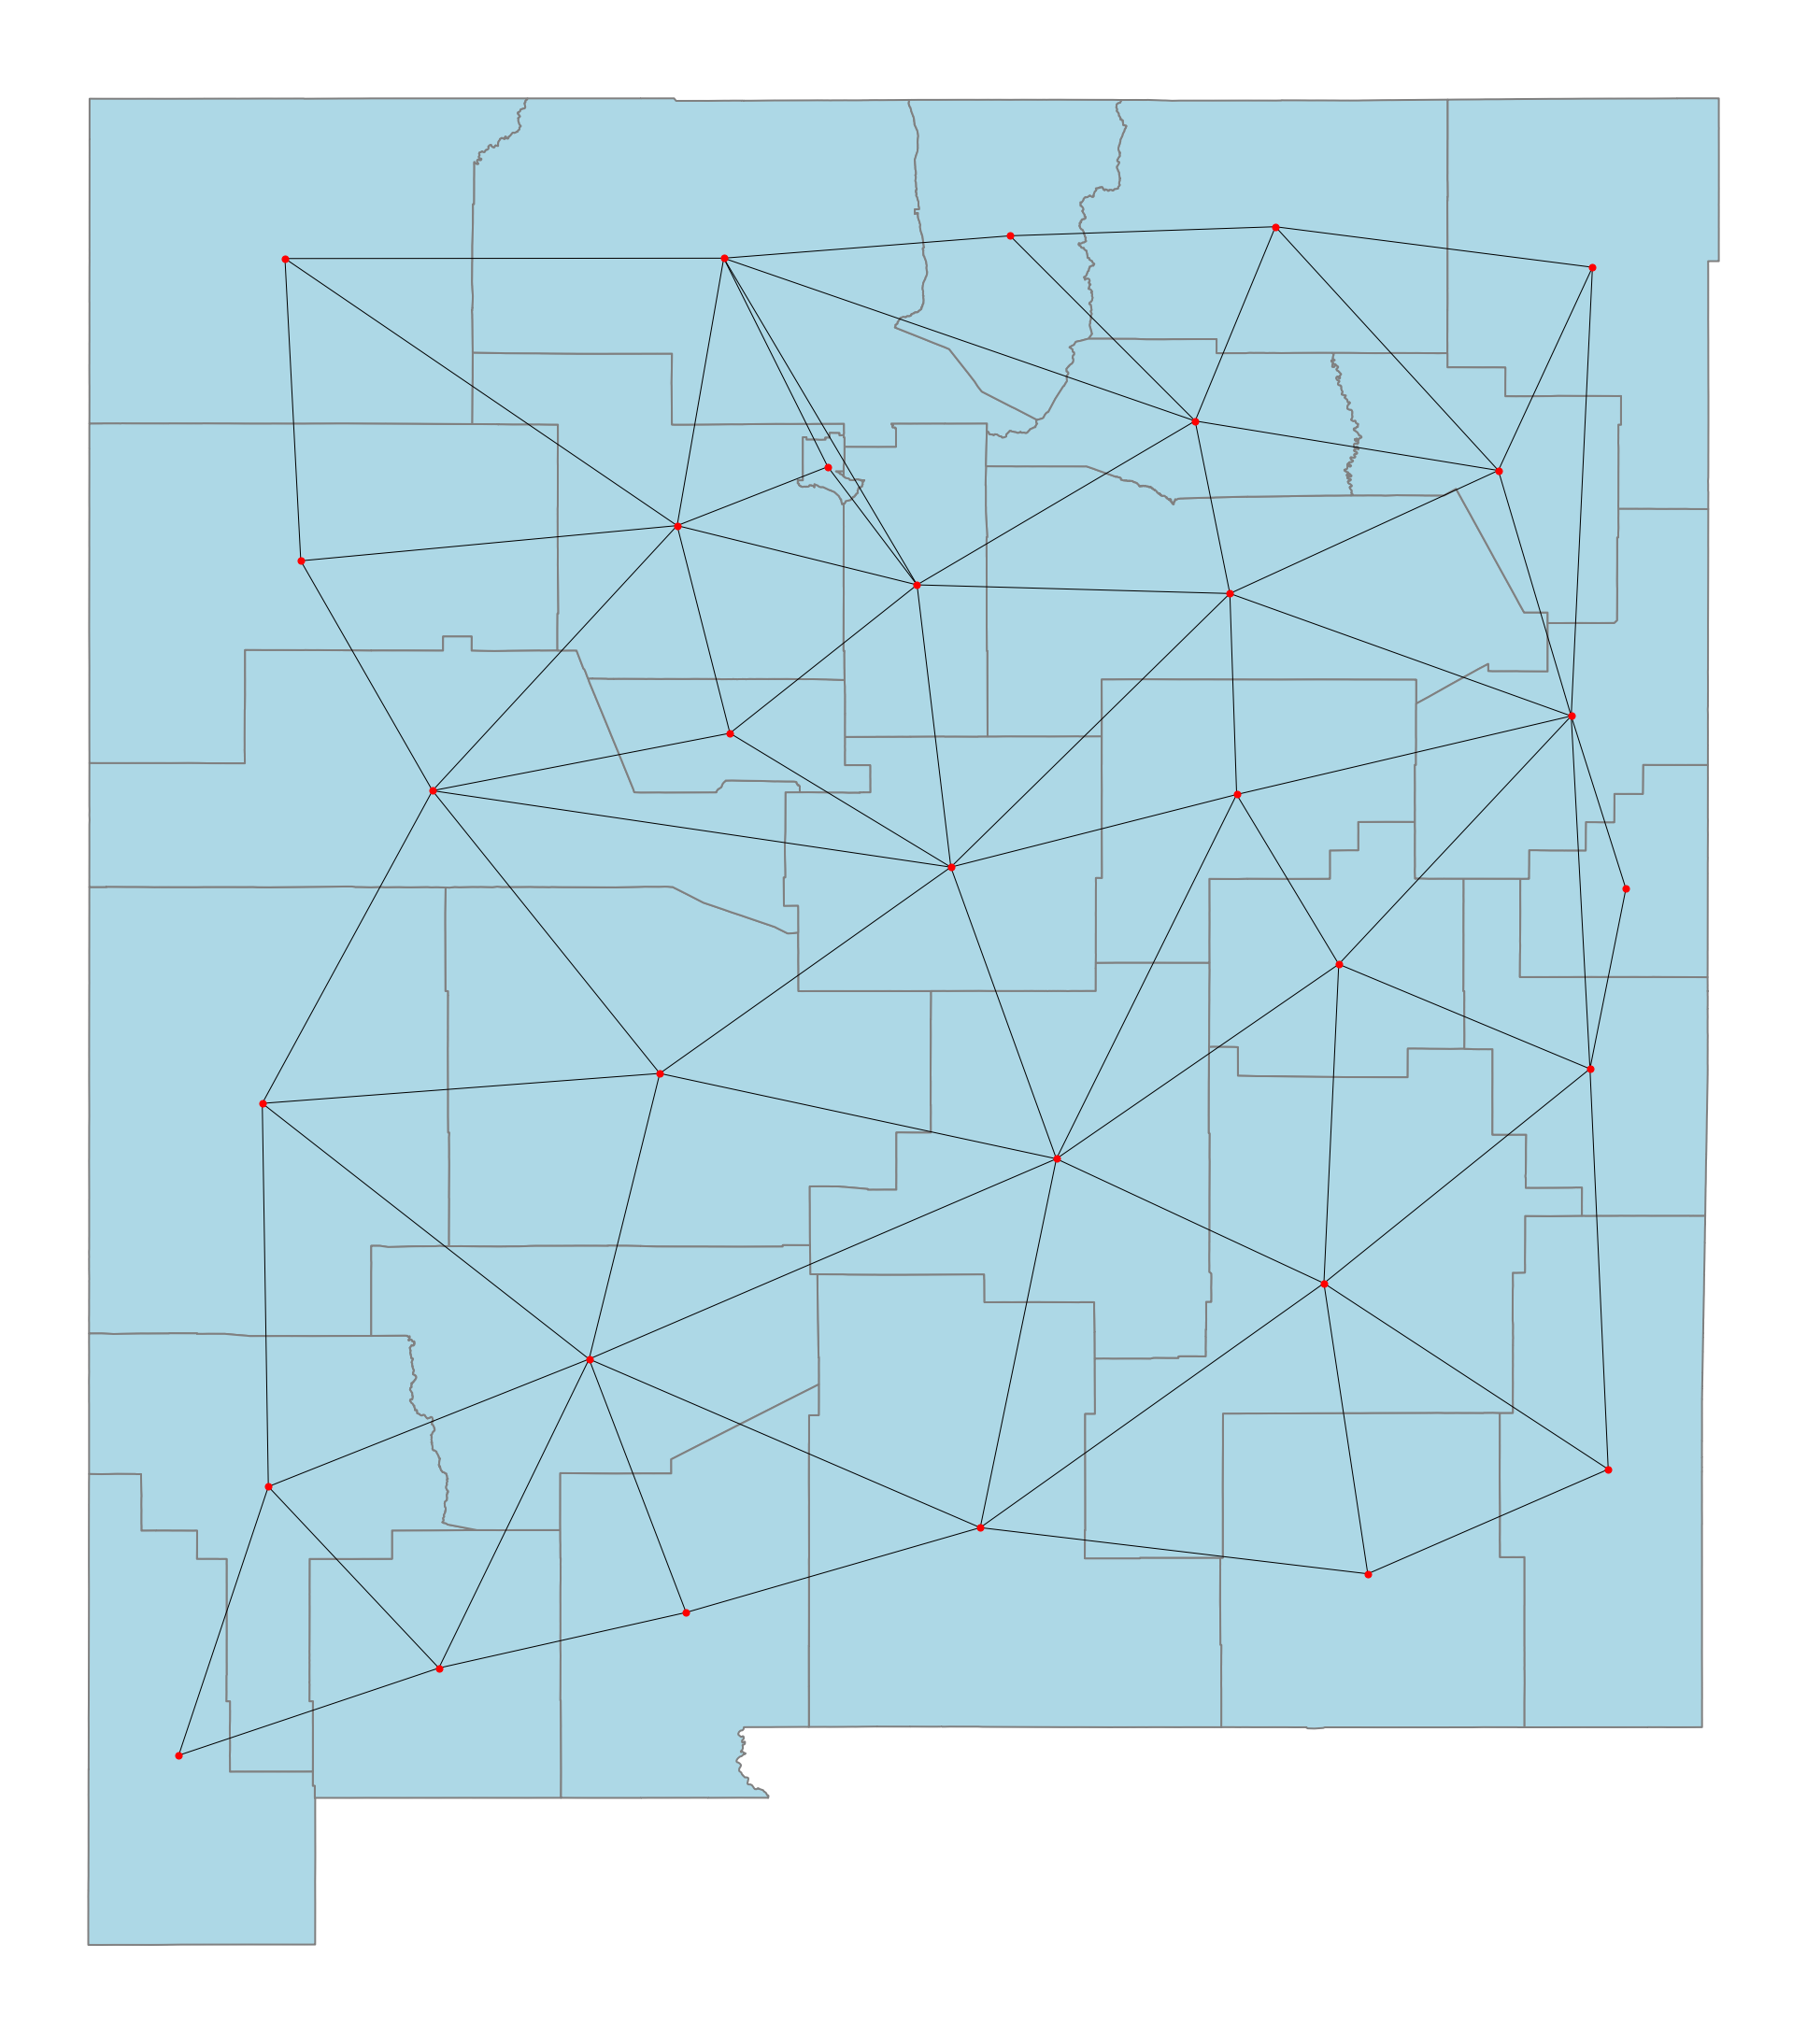

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
from echelon.contrib.geo import GISPlotter

plotter = GISPlotter(gdf, name_col='NAME00')
plotter.plot_adjacency(adjacency)
None